In [2]:
# standard library imports:

import os


# package imports:

import pandas as pd
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# general settings:

sns.set()

plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

In [5]:
# load the csv data prepared & exported by 'data_load_transform_EDA.ipynb'

df = pd.read_csv('predict_WTI.csv', index_col=0)

df

,price,t90d_mean,t30d_mean,f30d_mean,US Production,storage,gdp,f30d_mean_gdp,f365d_mean_gdp
1990-01-01,21.84,20.387000,21.151000,22.904667,7565,904134,9340.478778,9352.766670,9368.661736
1990-01-02,22.88,20.417111,21.238333,22.933000,7565,904134,9341.326219,9353.614111,9368.475865
1990-01-03,23.81,20.460000,21.357333,22.927333,7565,904134,9342.173660,9354.461552,9368.287526
1990-01-04,23.41,20.499111,21.463667,22.901667,7565,904134,9343.021100,9355.303125,9368.096719
1990-01-05,23.07,20.534444,21.550667,22.889333,7512,904076,9343.868541,9356.138830,9367.903444
...,...,...,...,...,...,...,...,...,...
2021-10-14,81.43,71.349222,75.840333,82.745000,11400,1043945,19617.739033,19653.189860,20048.135191
2021-10-15,82.39,71.467333,76.167000,82.726333,11300,1041820,19620.178531,19655.643559,20050.372550
2021-10-16,82.39,71.585444,76.490333,82.675667,11300,1041820,19622.618029,19658.098442,20052.607767
2021-10-17,82.39,71.762556,76.833667,82.624333,11300,1041820,19625.057527,19660.554507,20054.840844


In [6]:
# reduce the data for modeling a more recent period, and
# split into input (X) and output (y) datasets:

# X = df[-3000:].reset_index().drop(['f30d_mean', 'index'], axis=1)
# y = df[-3000:].reset_index()['f30d_mean']

X = df.reset_index(drop=True).drop('f30d_mean', axis=1)
y = df['f30d_mean'].reset_index(drop=True)

In [7]:
X

,price,t90d_mean,t30d_mean,US Production,storage,gdp,f30d_mean_gdp,f365d_mean_gdp
0,21.84,20.387000,21.151000,7565,904134,9340.478778,9352.766670,9368.661736
1,22.88,20.417111,21.238333,7565,904134,9341.326219,9353.614111,9368.475865
2,23.81,20.460000,21.357333,7565,904134,9342.173660,9354.461552,9368.287526
3,23.41,20.499111,21.463667,7565,904134,9343.021100,9355.303125,9368.096719
4,23.07,20.534444,21.550667,7512,904076,9343.868541,9356.138830,9367.903444
...,...,...,...,...,...,...,...,...
11608,81.43,71.349222,75.840333,11400,1043945,19617.739033,19653.189860,20048.135191
11609,82.39,71.467333,76.167000,11300,1041820,19620.178531,19655.643559,20050.372550
11610,82.39,71.585444,76.490333,11300,1041820,19622.618029,19658.098442,20052.607767
11611,82.39,71.762556,76.833667,11300,1041820,19625.057527,19660.554507,20054.840844


In [8]:
y

0        22.904667
1        22.933000
2        22.927333
3        22.901667
4        22.889333
           ...    
11608    82.745000
11609    82.726333
11610    82.675667
11611    82.624333
11612    82.570000
Name: f30d_mean, Length: 11613, dtype: float64

In [9]:
# create the train-test split:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scal = RobustScaler()

X_train = scal.fit_transform(X_train)
X_test = scal.transform(X_test)

In [10]:
# examine X and y shapes:

print('X shape: ' + str(X.shape))
print('y shape: ' + str(y.shape))
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))

X shape: (11613, 8)
y shape: (11613,)
X_train shape: (8129, 8)
y_train shape: (8129,)


In [11]:
# build the neural network:

mod = Sequential()

mod.add(Dense(128, activation='relu'))
mod.add(Dense(128, activation='relu'))
mod.add(Dense(128, activation='relu'))
mod.add(Dense(1))

mod.compile(optimizer='adam', loss='mse')


# set up early stopping:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# set up checkpoints to recall the best model:
model_cp = tf.keras.callbacks.ModelCheckpoint('models_best_nn.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [12]:
mod.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[early_stop, model_cp], verbose=0)


Epoch 00001: val_loss improved from inf to 22.74394, saving model to best_cp.h5

Epoch 00002: val_loss improved from 22.74394 to 12.31299, saving model to best_cp.h5

Epoch 00003: val_loss improved from 12.31299 to 10.85624, saving model to best_cp.h5

Epoch 00004: val_loss improved from 10.85624 to 9.01901, saving model to best_cp.h5

Epoch 00005: val_loss did not improve from 9.01901

Epoch 00006: val_loss improved from 9.01901 to 8.83966, saving model to best_cp.h5

Epoch 00007: val_loss did not improve from 8.83966

Epoch 00008: val_loss did not improve from 8.83966

Epoch 00009: val_loss improved from 8.83966 to 8.25980, saving model to best_cp.h5

Epoch 00010: val_loss did not improve from 8.25980

Epoch 00011: val_loss improved from 8.25980 to 8.06722, saving model to best_cp.h5

Epoch 00012: val_loss improved from 8.06722 to 7.83232, saving model to best_cp.h5

Epoch 00013: val_loss improved from 7.83232 to 7.69058, saving model to best_cp.h5

Epoch 00014: val_loss improved fr


Epoch 00139: val_loss improved from 3.23218 to 3.19050, saving model to best_cp.h5

Epoch 00140: val_loss did not improve from 3.19050

Epoch 00141: val_loss did not improve from 3.19050

Epoch 00142: val_loss improved from 3.19050 to 3.18719, saving model to best_cp.h5

Epoch 00143: val_loss did not improve from 3.18719

Epoch 00144: val_loss did not improve from 3.18719

Epoch 00145: val_loss did not improve from 3.18719

Epoch 00146: val_loss did not improve from 3.18719

Epoch 00147: val_loss did not improve from 3.18719

Epoch 00148: val_loss improved from 3.18719 to 2.99754, saving model to best_cp.h5

Epoch 00149: val_loss did not improve from 2.99754

Epoch 00150: val_loss did not improve from 2.99754

Epoch 00151: val_loss did not improve from 2.99754

Epoch 00152: val_loss did not improve from 2.99754

Epoch 00153: val_loss did not improve from 2.99754

Epoch 00154: val_loss did not improve from 2.99754

Epoch 00155: val_loss did not improve from 2.99754

Epoch 00156: val_lo


Epoch 00288: val_loss did not improve from 1.83006

Epoch 00289: val_loss did not improve from 1.83006

Epoch 00290: val_loss did not improve from 1.83006

Epoch 00291: val_loss did not improve from 1.83006

Epoch 00292: val_loss did not improve from 1.83006

Epoch 00293: val_loss improved from 1.83006 to 1.73000, saving model to best_cp.h5

Epoch 00294: val_loss improved from 1.73000 to 1.62968, saving model to best_cp.h5

Epoch 00295: val_loss did not improve from 1.62968

Epoch 00296: val_loss did not improve from 1.62968

Epoch 00297: val_loss did not improve from 1.62968

Epoch 00298: val_loss did not improve from 1.62968

Epoch 00299: val_loss did not improve from 1.62968

Epoch 00300: val_loss did not improve from 1.62968

Epoch 00301: val_loss did not improve from 1.62968

Epoch 00302: val_loss did not improve from 1.62968

Epoch 00303: val_loss did not improve from 1.62968

Epoch 00304: val_loss did not improve from 1.62968

Epoch 00305: val_loss did not improve from 1.62968



Epoch 00438: val_loss did not improve from 1.20675

Epoch 00439: val_loss did not improve from 1.20675

Epoch 00440: val_loss did not improve from 1.20675

Epoch 00441: val_loss did not improve from 1.20675

Epoch 00442: val_loss did not improve from 1.20675

Epoch 00443: val_loss did not improve from 1.20675

Epoch 00444: val_loss did not improve from 1.20675

Epoch 00445: val_loss did not improve from 1.20675

Epoch 00446: val_loss did not improve from 1.20675

Epoch 00447: val_loss did not improve from 1.20675

Epoch 00448: val_loss did not improve from 1.20675

Epoch 00449: val_loss did not improve from 1.20675

Epoch 00450: val_loss did not improve from 1.20675

Epoch 00451: val_loss did not improve from 1.20675

Epoch 00452: val_loss did not improve from 1.20675

Epoch 00453: val_loss did not improve from 1.20675

Epoch 00454: val_loss did not improve from 1.20675

Epoch 00455: val_loss improved from 1.20675 to 1.20665, saving model to best_cp.h5

Epoch 00456: val_loss improved 


Epoch 00590: val_loss did not improve from 0.85558

Epoch 00591: val_loss did not improve from 0.85558

Epoch 00592: val_loss did not improve from 0.85558

Epoch 00593: val_loss did not improve from 0.85558

Epoch 00594: val_loss did not improve from 0.85558

Epoch 00595: val_loss did not improve from 0.85558

Epoch 00596: val_loss did not improve from 0.85558

Epoch 00597: val_loss did not improve from 0.85558

Epoch 00598: val_loss did not improve from 0.85558

Epoch 00599: val_loss did not improve from 0.85558

Epoch 00600: val_loss did not improve from 0.85558

Epoch 00601: val_loss improved from 0.85558 to 0.83770, saving model to best_cp.h5

Epoch 00602: val_loss did not improve from 0.83770

Epoch 00603: val_loss did not improve from 0.83770

Epoch 00604: val_loss did not improve from 0.83770

Epoch 00605: val_loss did not improve from 0.83770

Epoch 00606: val_loss did not improve from 0.83770

Epoch 00607: val_loss did not improve from 0.83770

Epoch 00608: val_loss did not i

(0.0, 20.0)

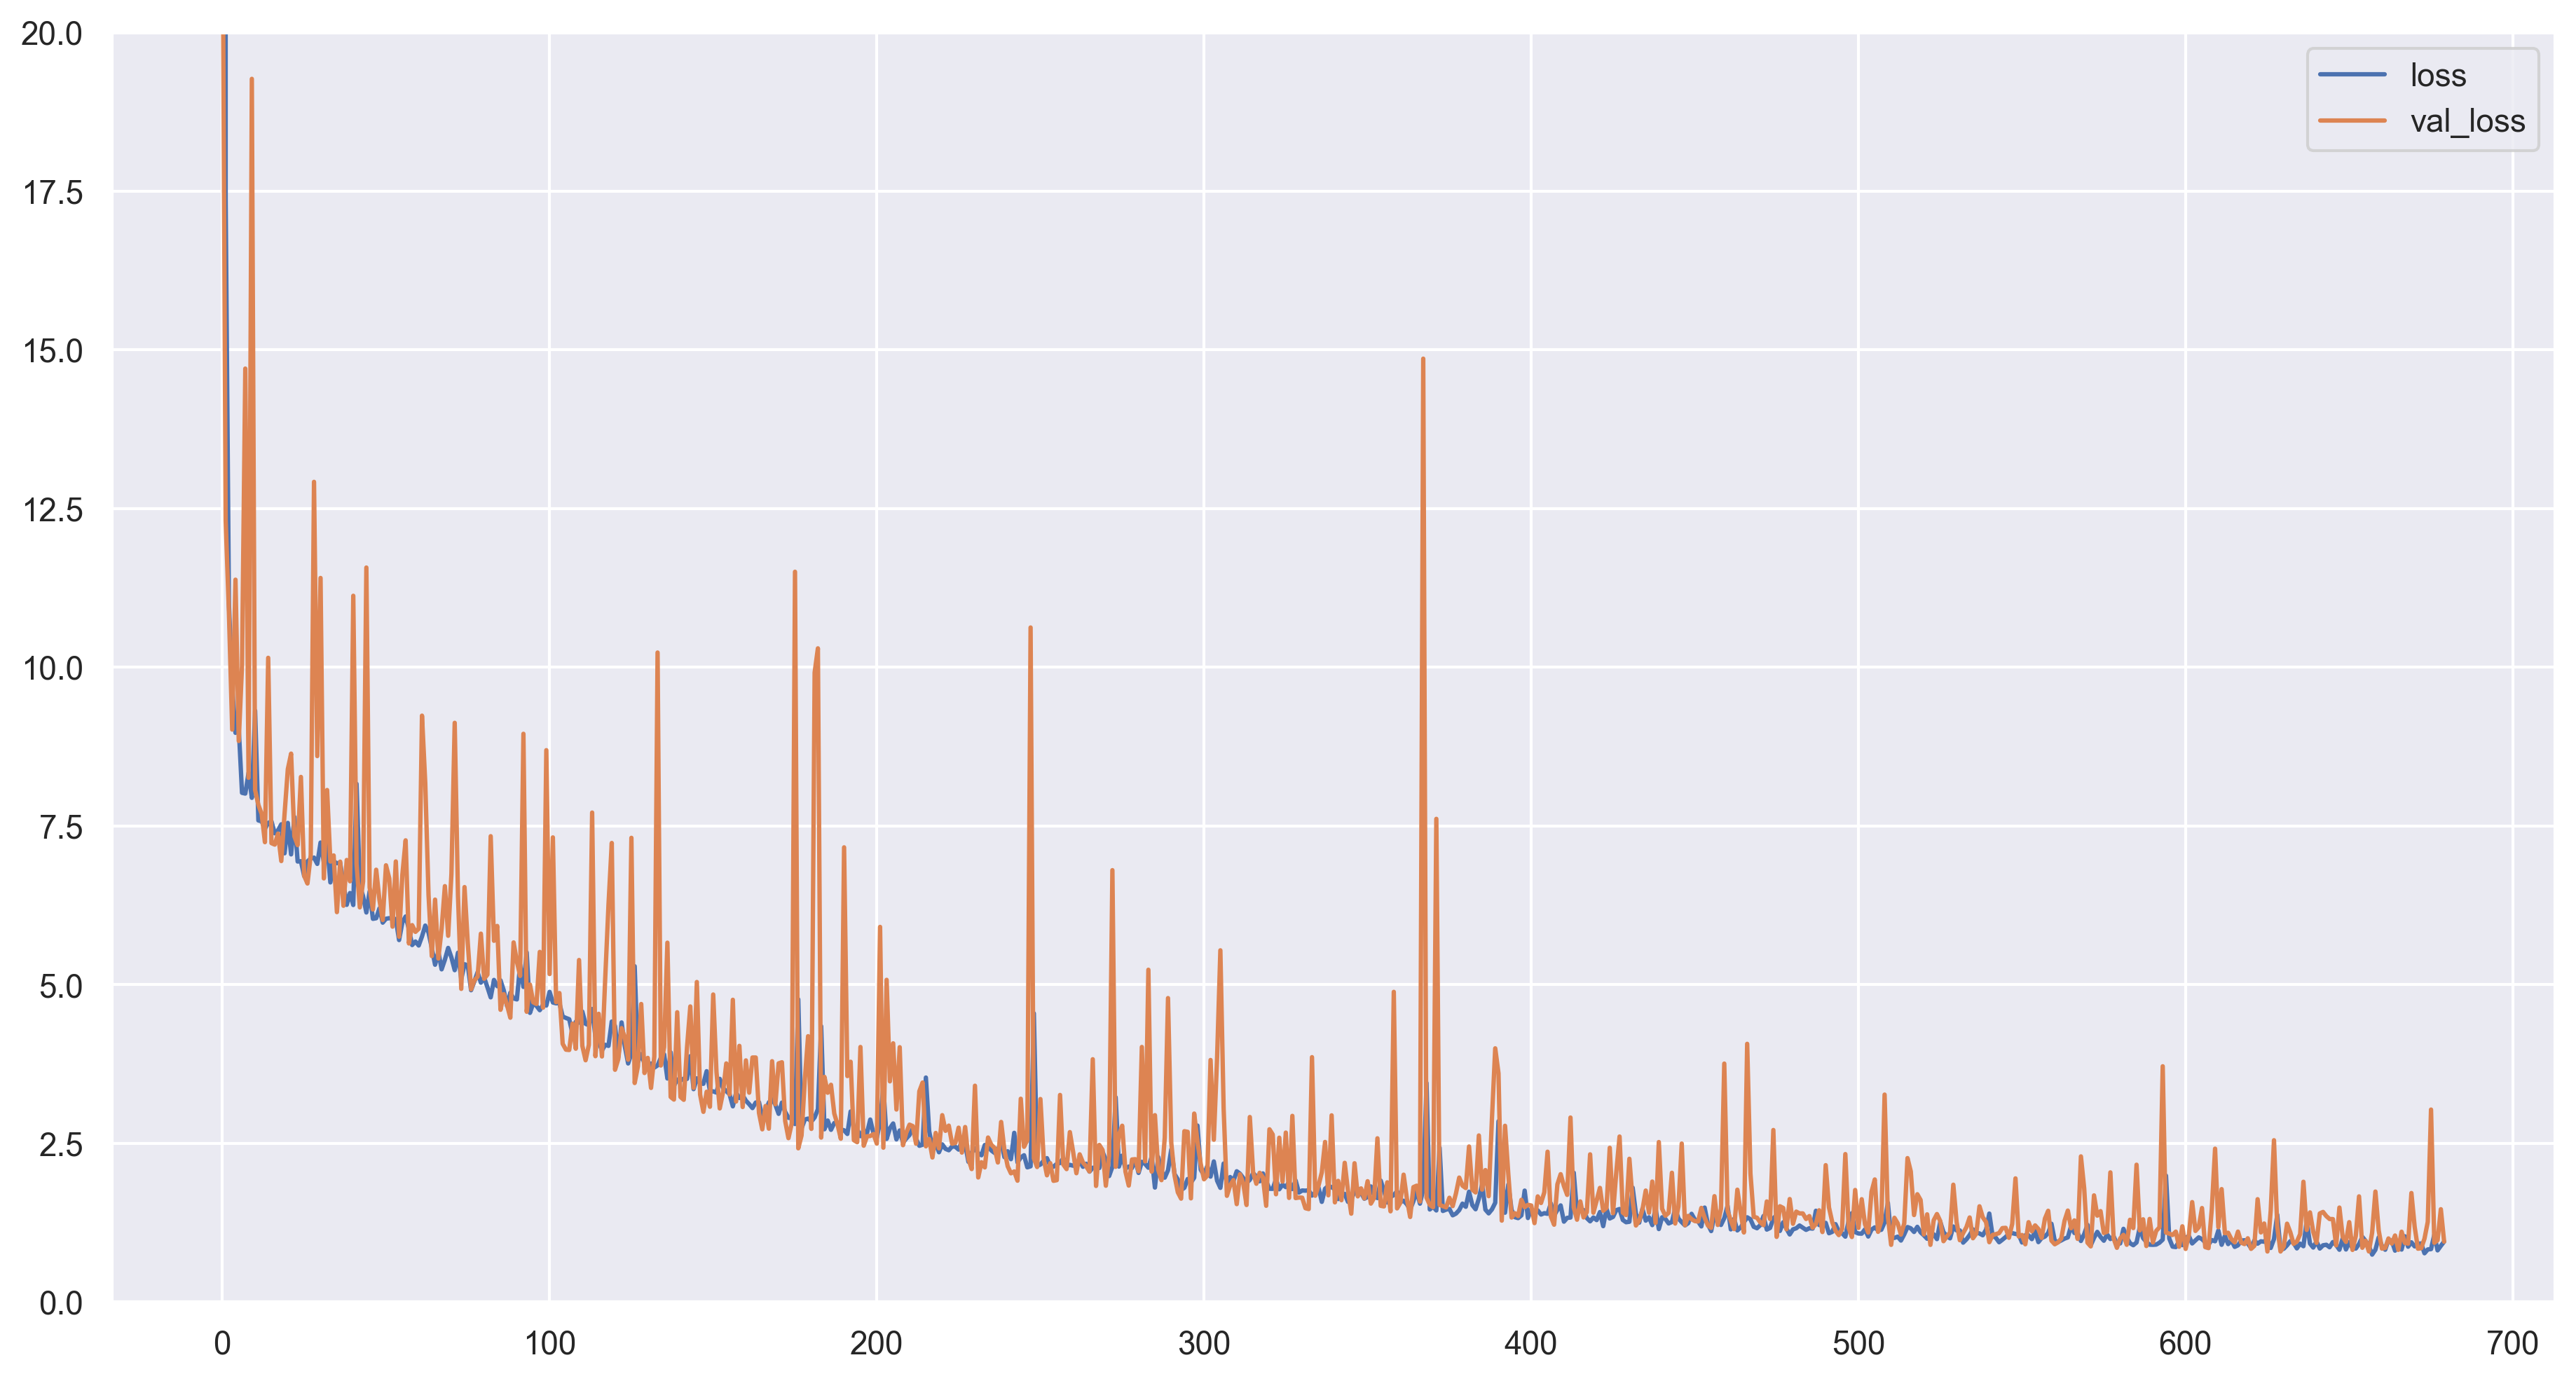

In [13]:
# view the history of model loss & validation loss:

history = pd.DataFrame(mod.history.history).plot()
history

plt.ylim(0, 20)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 145.78884999999997)

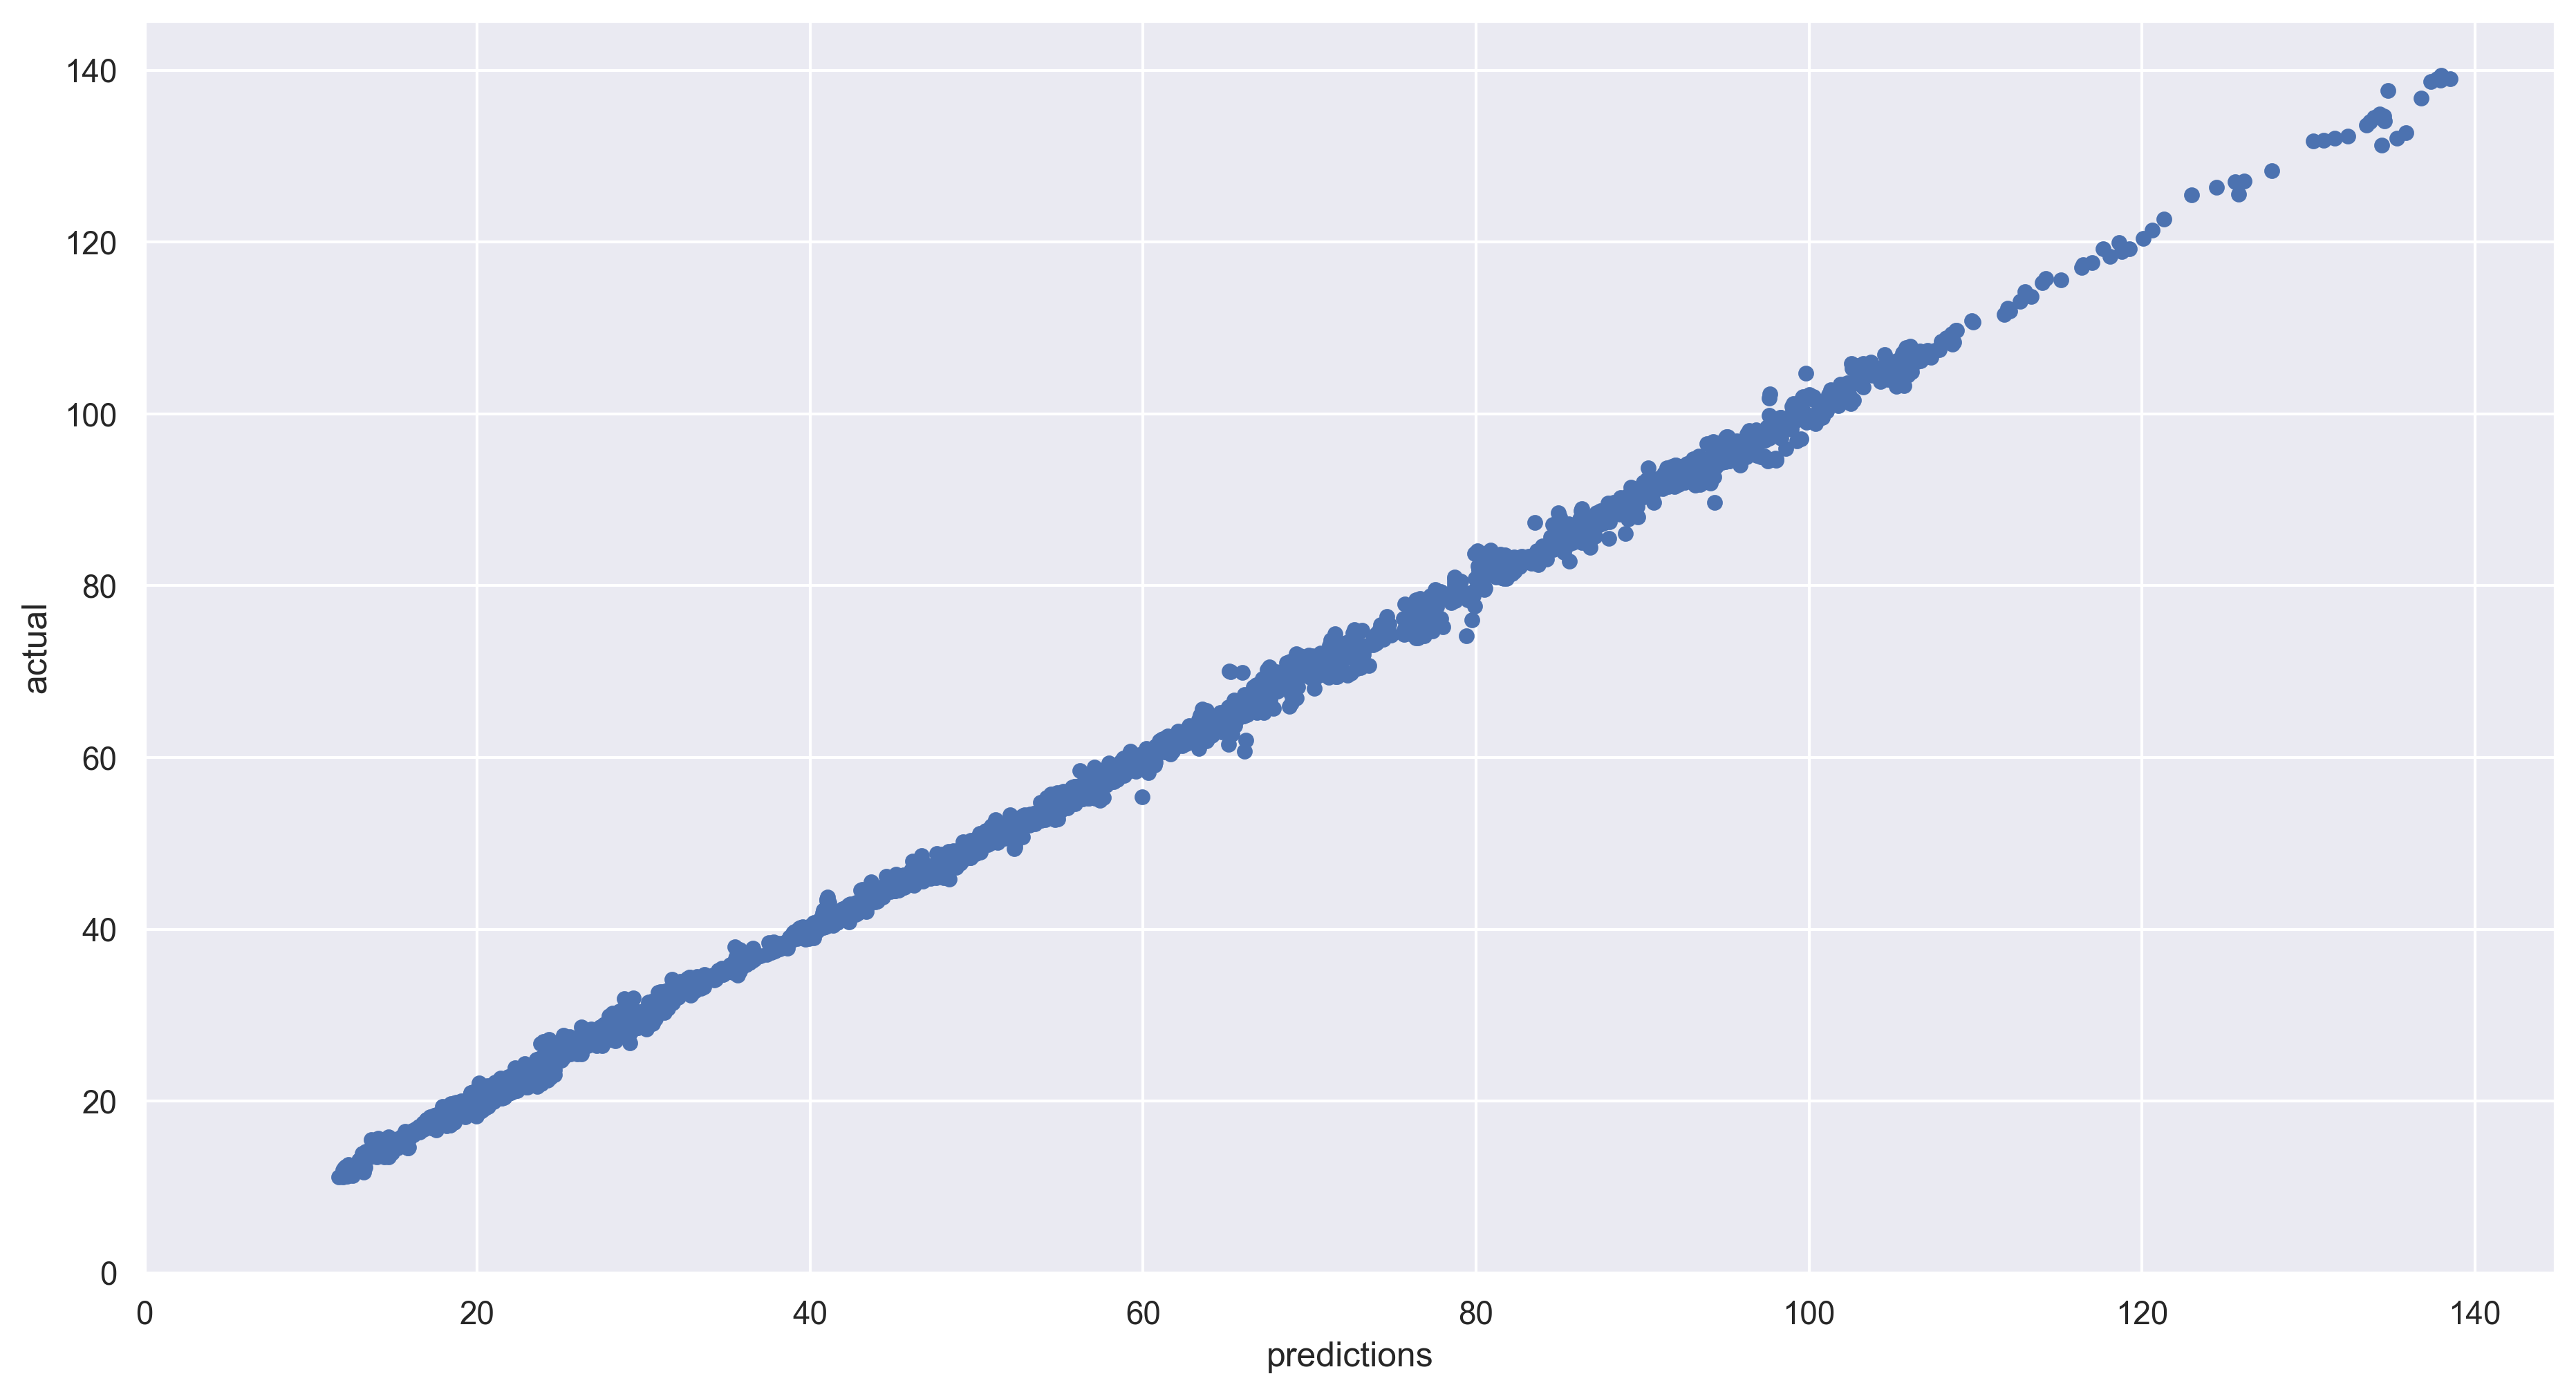

In [14]:
# recall the best model:
mod = tf.keras.models.load_model('models_best_nn.h5')


# create and view predictions versus actual for test data:

predictions = mod.predict(X_test).reshape(y_test.shape)
pd.DataFrame({'predictions': predictions, 'actual': y_test}).plot.scatter(x='predictions', y='actual', figsize=(15,8))
plt.xlim(0,)
plt.ylim(0,)

In [15]:
# add a model prediction column to the original dataframe
# (note the model does not treat the data as a time series):

ts = df.copy()
ts['f30d_pred'] = mod.predict(scal.transform(df[X.columns].values))
ts

,price,t90d_mean,t30d_mean,f30d_mean,US Production,storage,gdp,f30d_mean_gdp,f365d_mean_gdp,f30d_pred
1990-01-01,21.84,20.387000,21.151000,22.904667,7565,904134,9340.478778,9352.766670,9368.661736,22.068642
1990-01-02,22.88,20.417111,21.238333,22.933000,7565,904134,9341.326219,9353.614111,9368.475865,22.521278
1990-01-03,23.81,20.460000,21.357333,22.927333,7565,904134,9342.173660,9354.461552,9368.287526,22.934864
1990-01-04,23.41,20.499111,21.463667,22.901667,7565,904134,9343.021100,9355.303125,9368.096719,22.805721
1990-01-05,23.07,20.534444,21.550667,22.889333,7512,904076,9343.868541,9356.138830,9367.903444,22.686672
...,...,...,...,...,...,...,...,...,...,...
2021-10-14,81.43,71.349222,75.840333,82.745000,11400,1043945,19617.739033,19653.189860,20048.135191,81.345497
2021-10-15,82.39,71.467333,76.167000,82.726333,11300,1041820,19620.178531,19655.643559,20050.372550,82.059761
2021-10-16,82.39,71.585444,76.490333,82.675667,11300,1041820,19622.618029,19658.098442,20052.607767,81.820061
2021-10-17,82.39,71.762556,76.833667,82.624333,11300,1041820,19625.057527,19660.554507,20054.840844,81.550575


<AxesSubplot:>

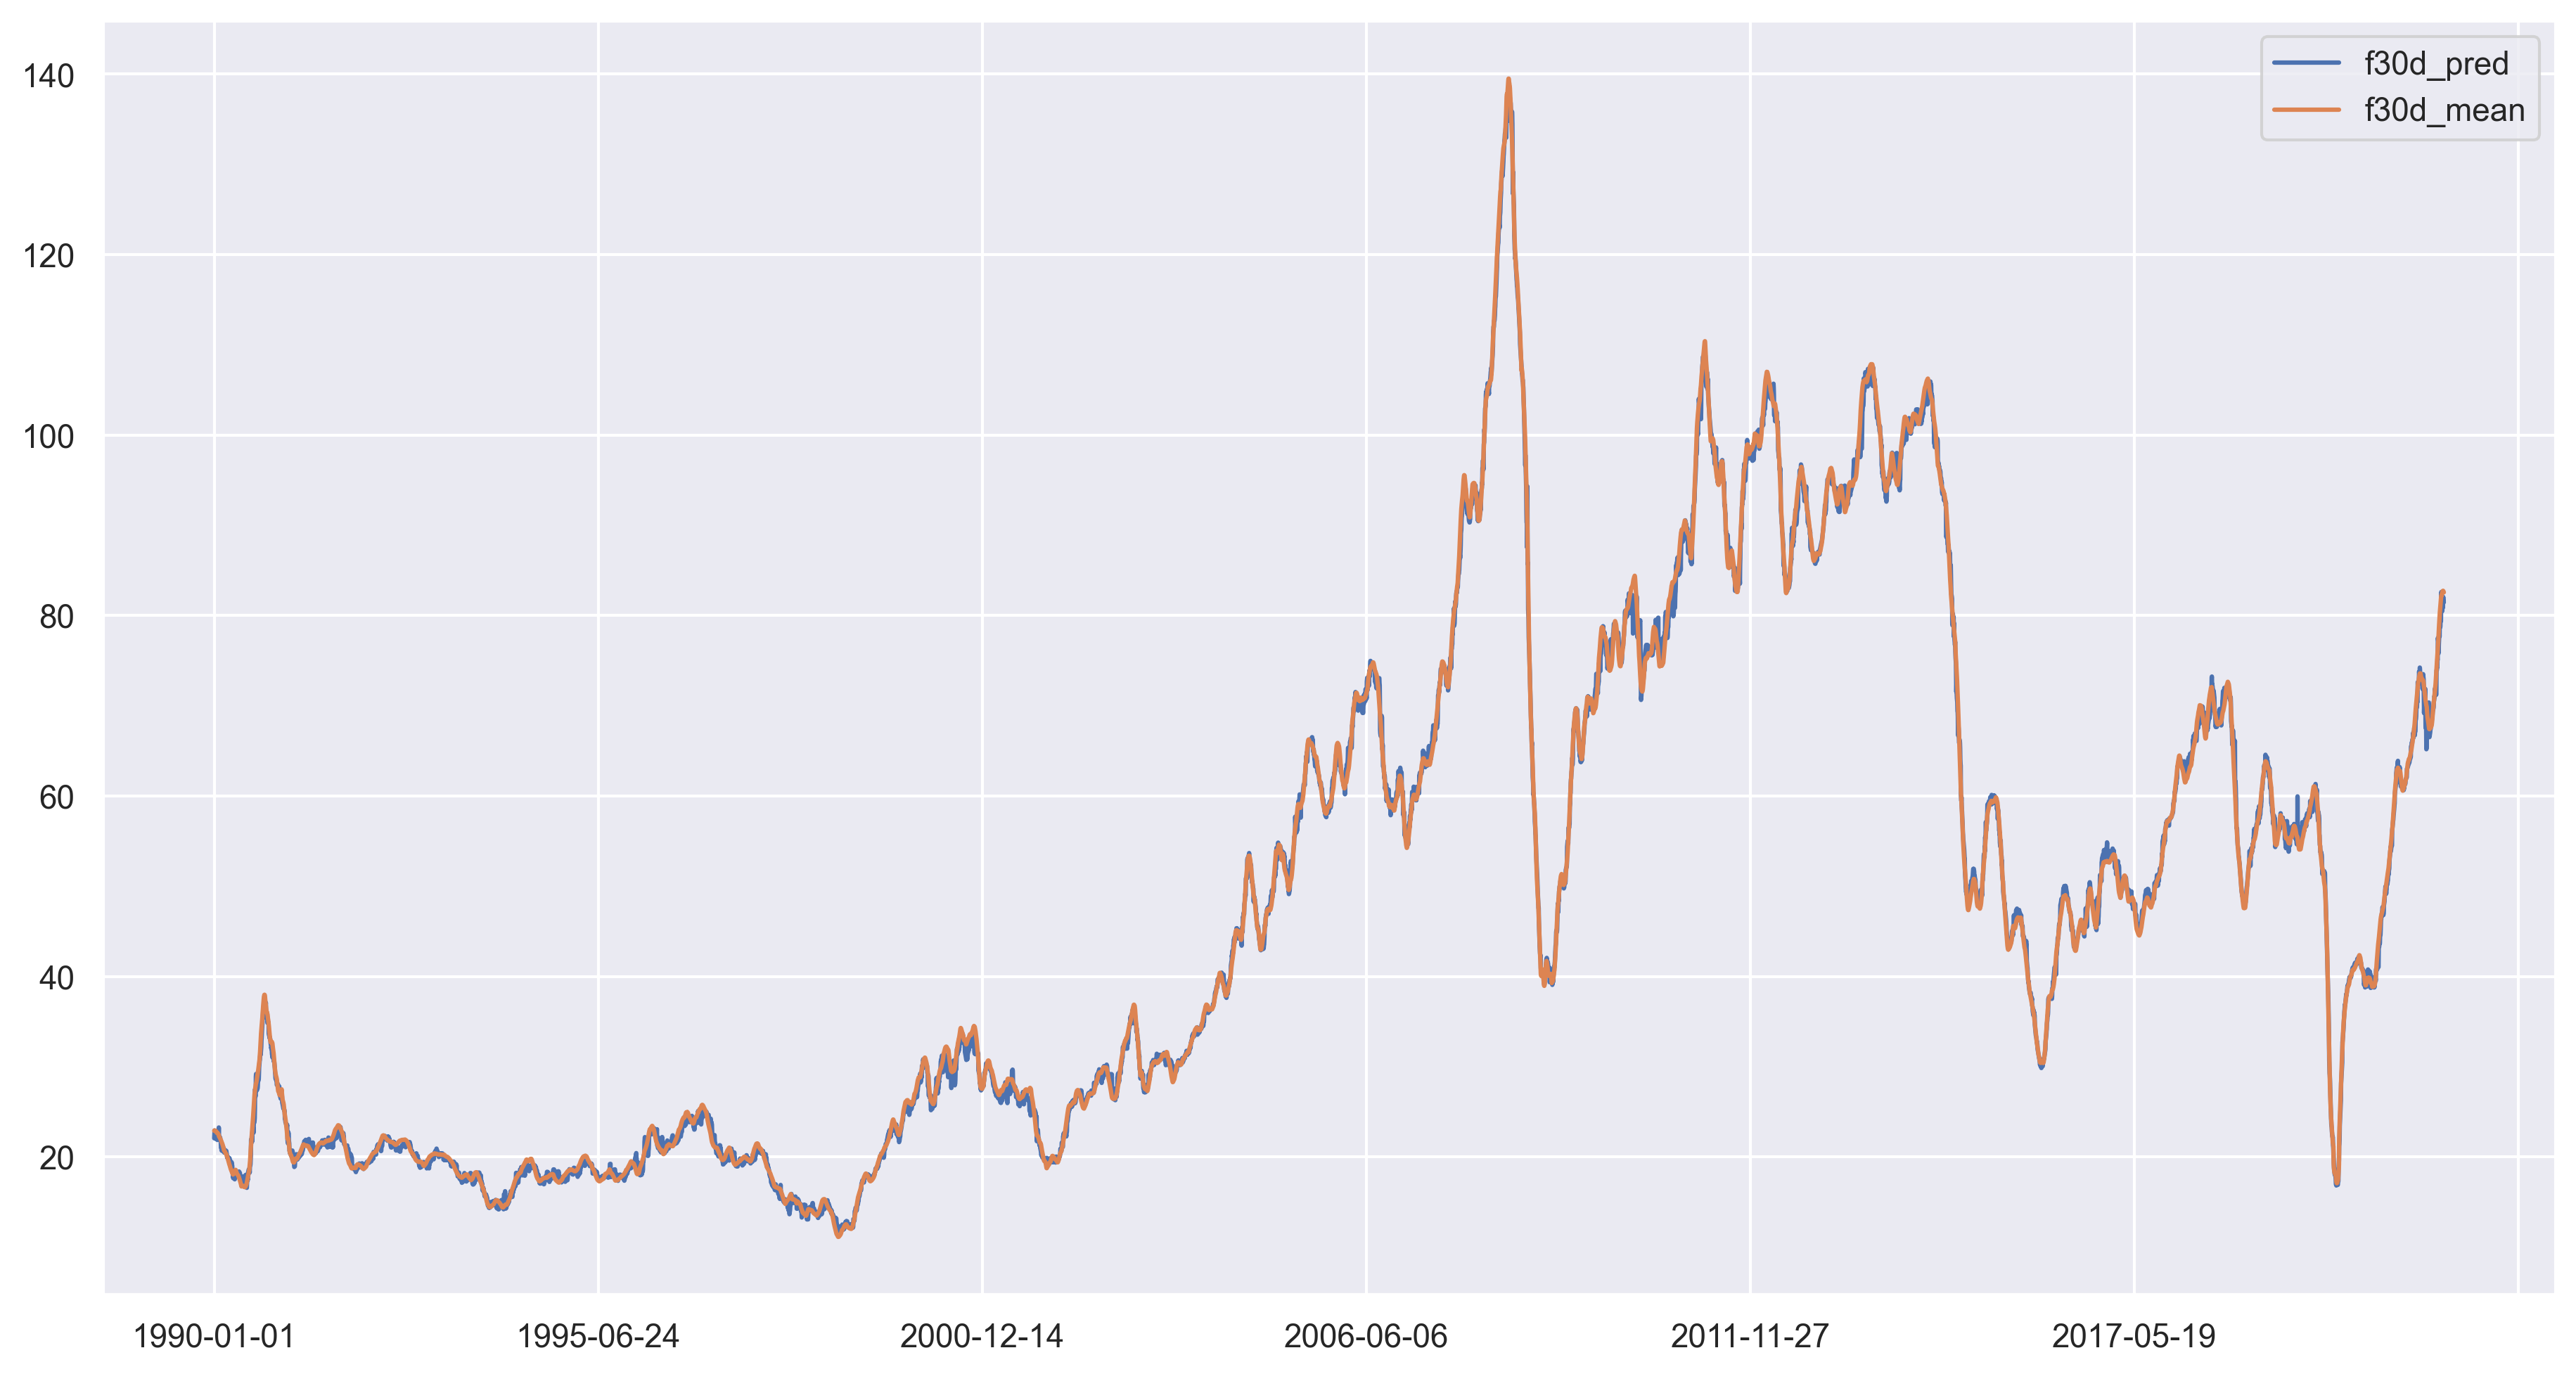

In [16]:
ts[['f30d_pred', 'f30d_mean']].plot(figsize=(15,8))

<AxesSubplot:>

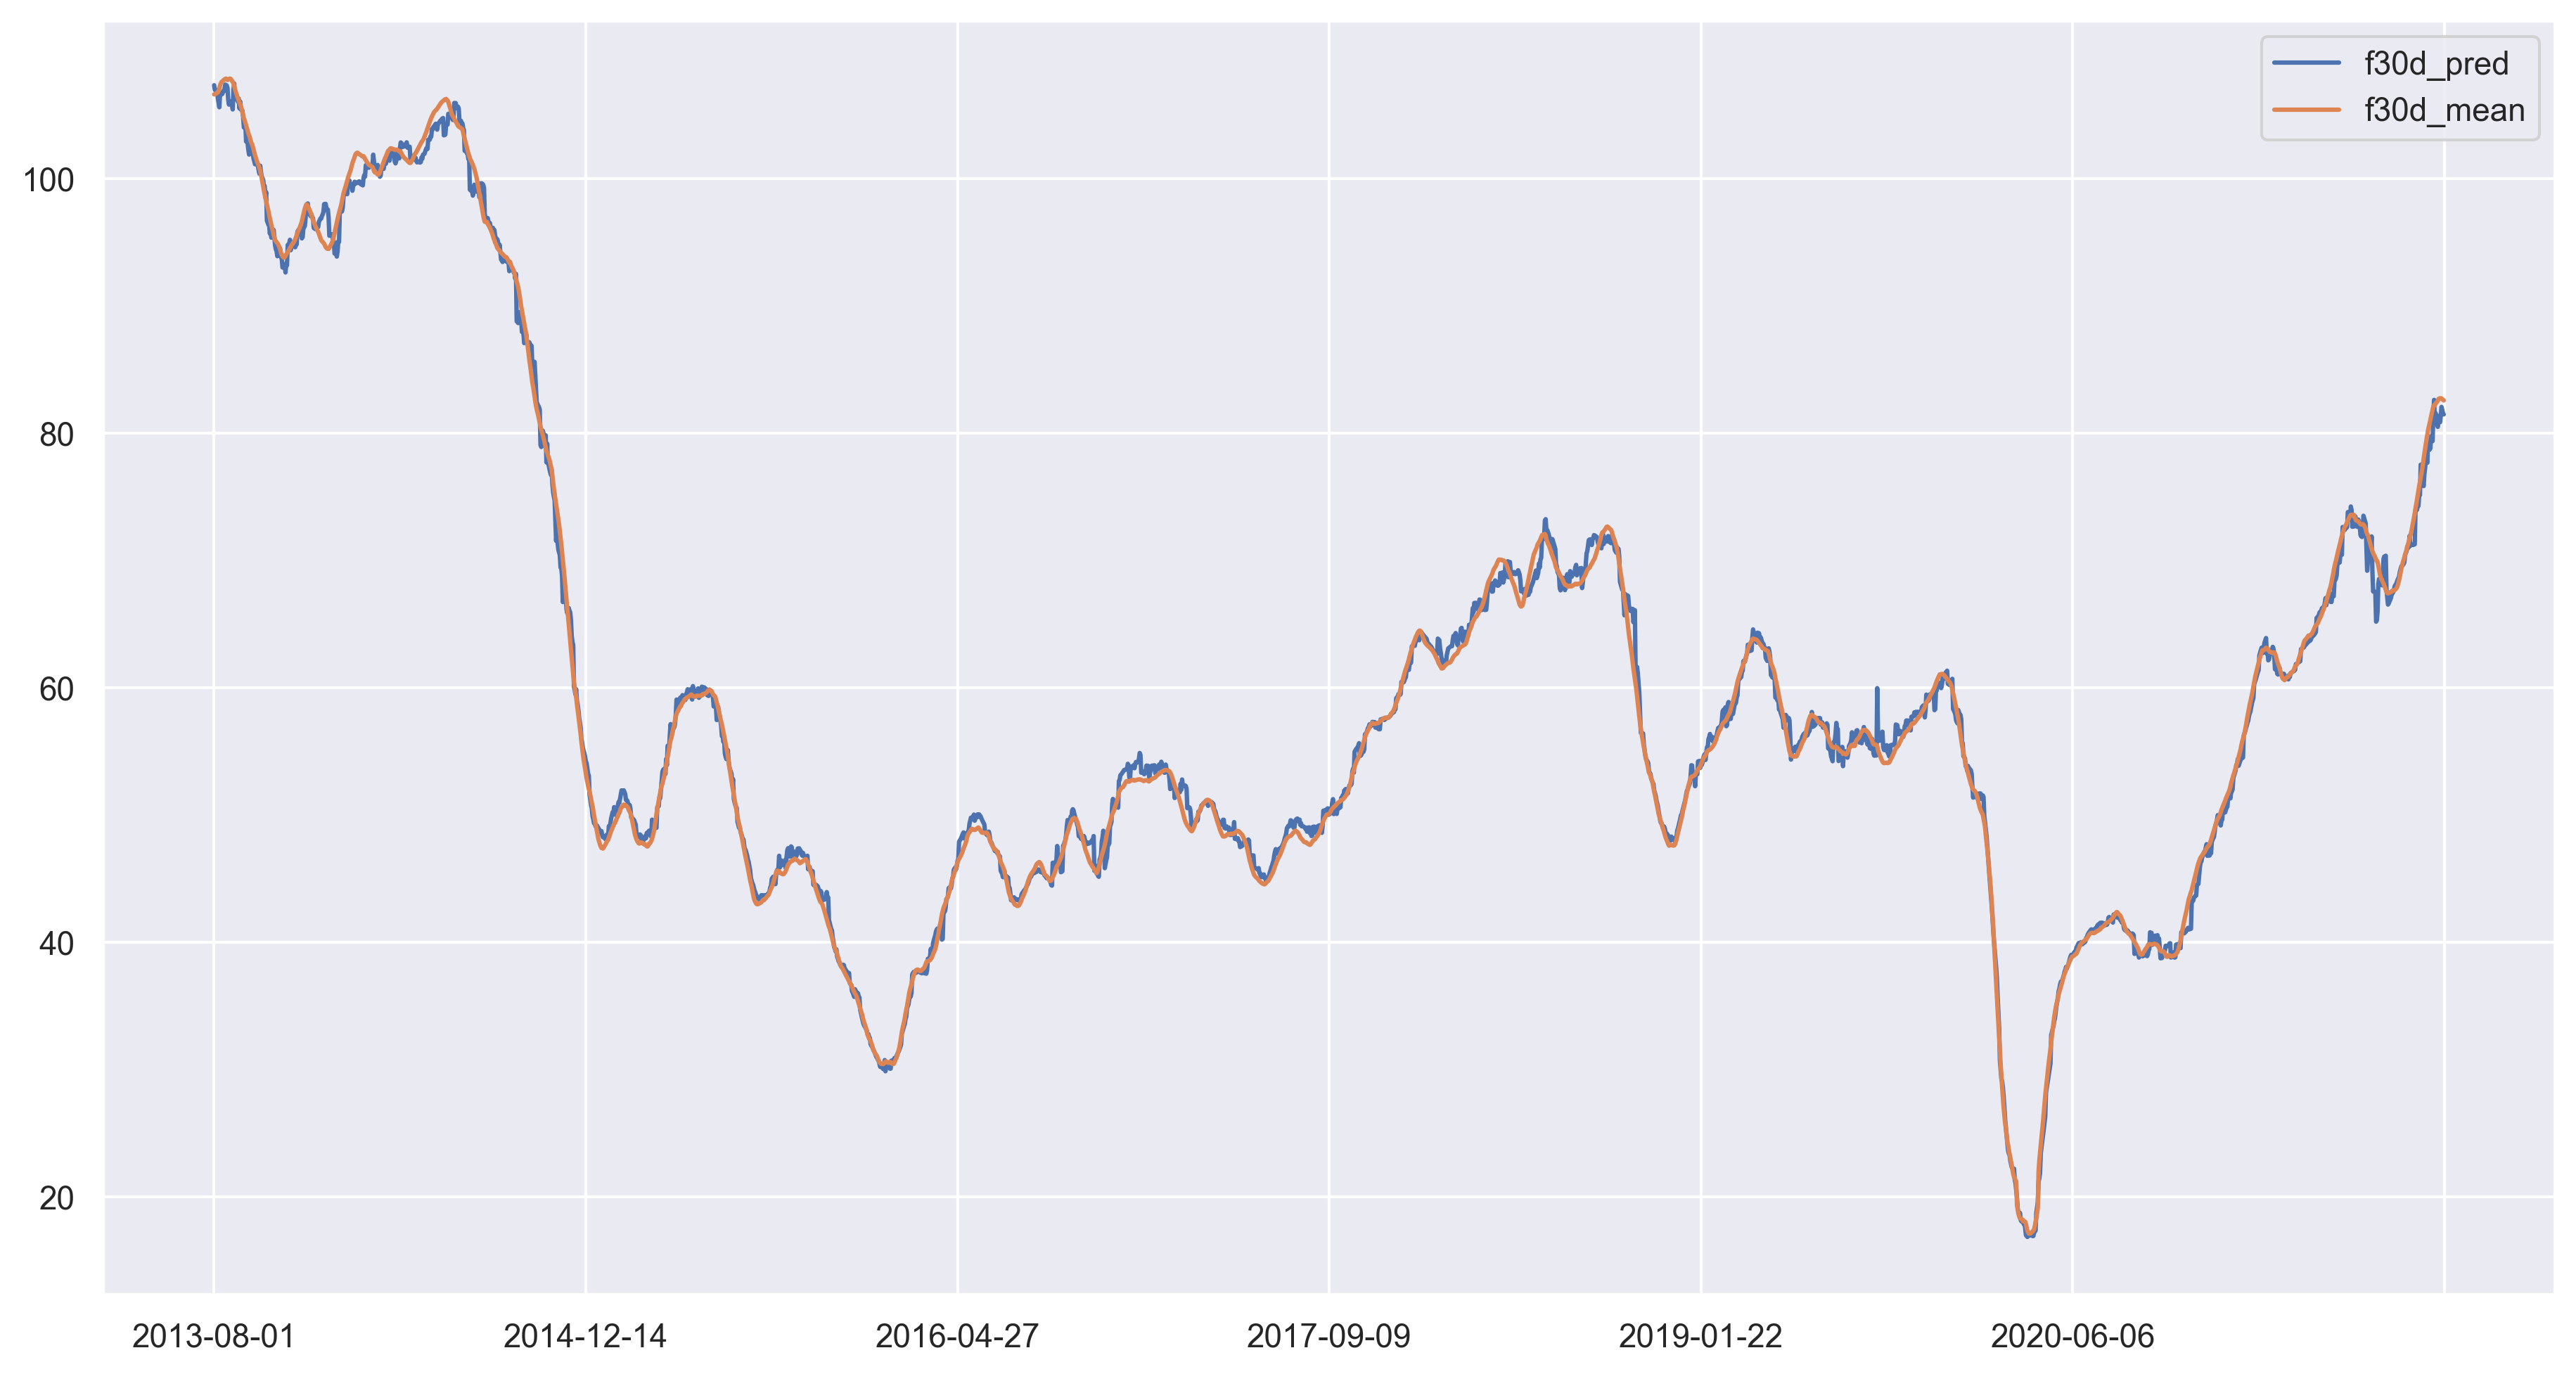

In [17]:
ts[-3000:][['f30d_pred', 'f30d_mean']].plot(figsize=(15,8))

(0.0, 86.43674999999999)

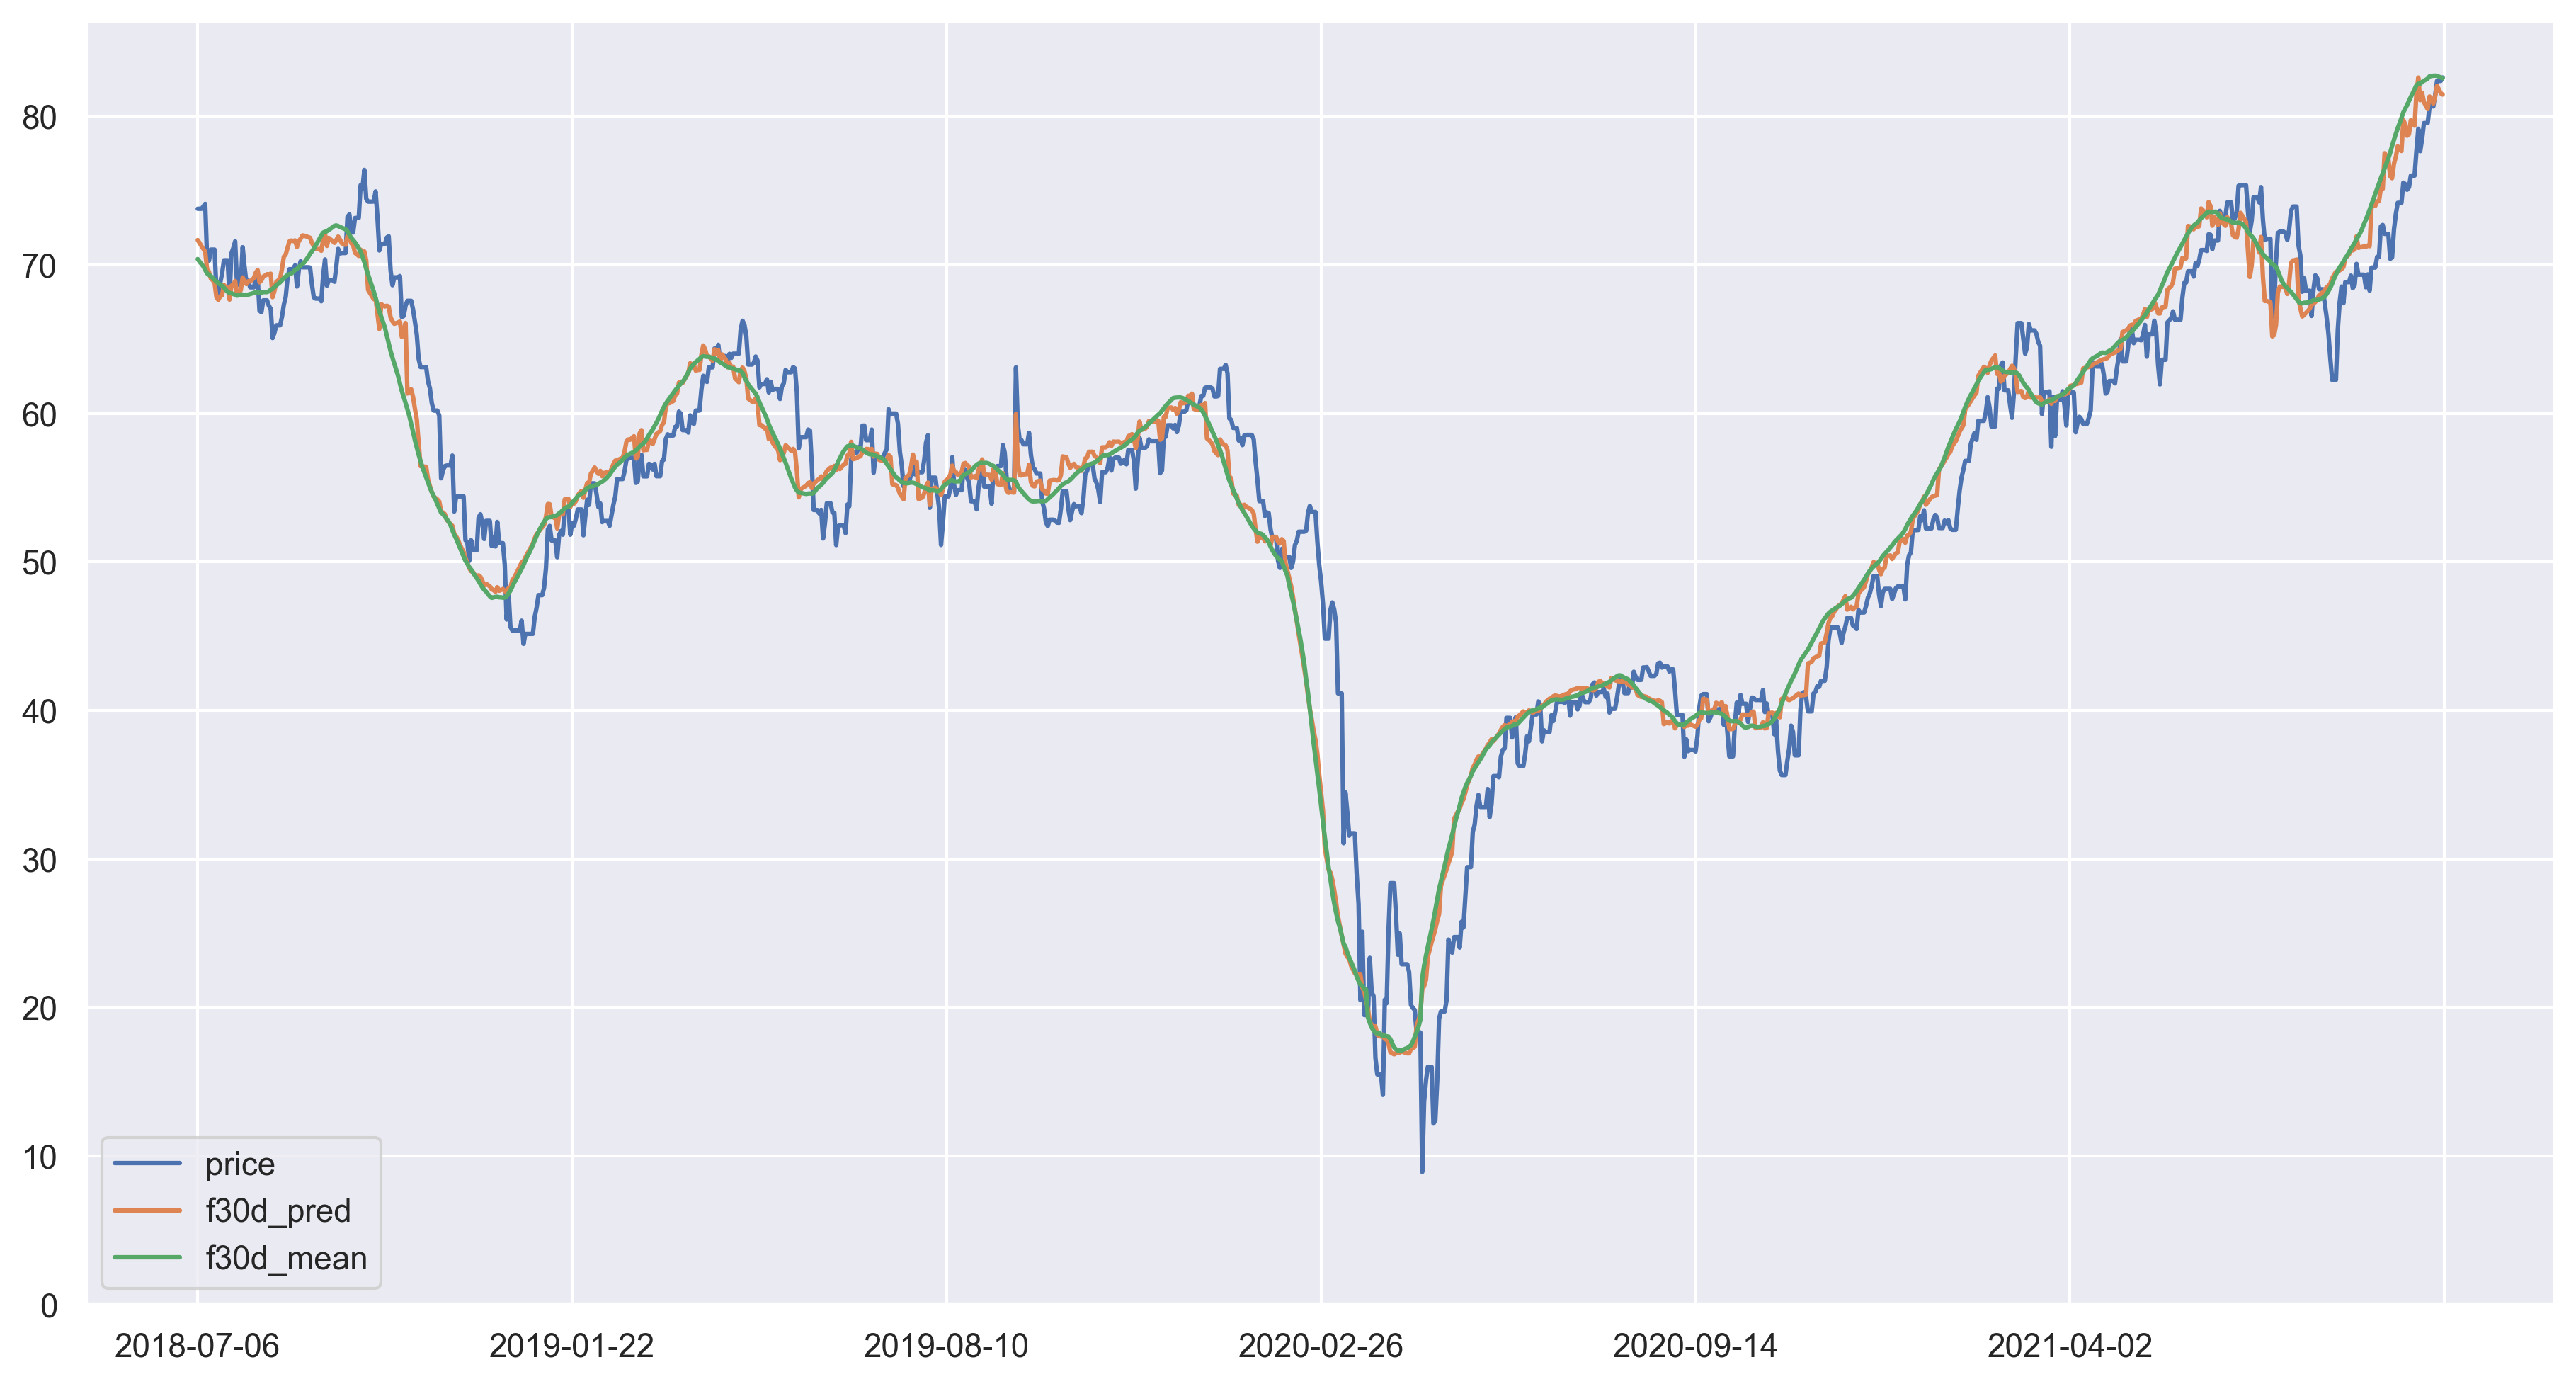

In [18]:
ts[-1200:][['price', 'f30d_pred', 'f30d_mean']].plot()

plt.ylim(0,)

<h1><u>Comparison to Baseline</u></h1>

### It's common to base economic analysis on the presumption, for lack of better information, that ongoing oil prices remain flat. The model at issue should at least improve upon this as a baseline. 

#### I'm considering two alternative baselines which may add to or replace the current (daily spot rate) baseline:
- 30-days average spot price (similar to daily but more stable)
- Trailing 12-months average spot price (basis for SEC booked reserves economics)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='price', ylabel='f30d_mean'>

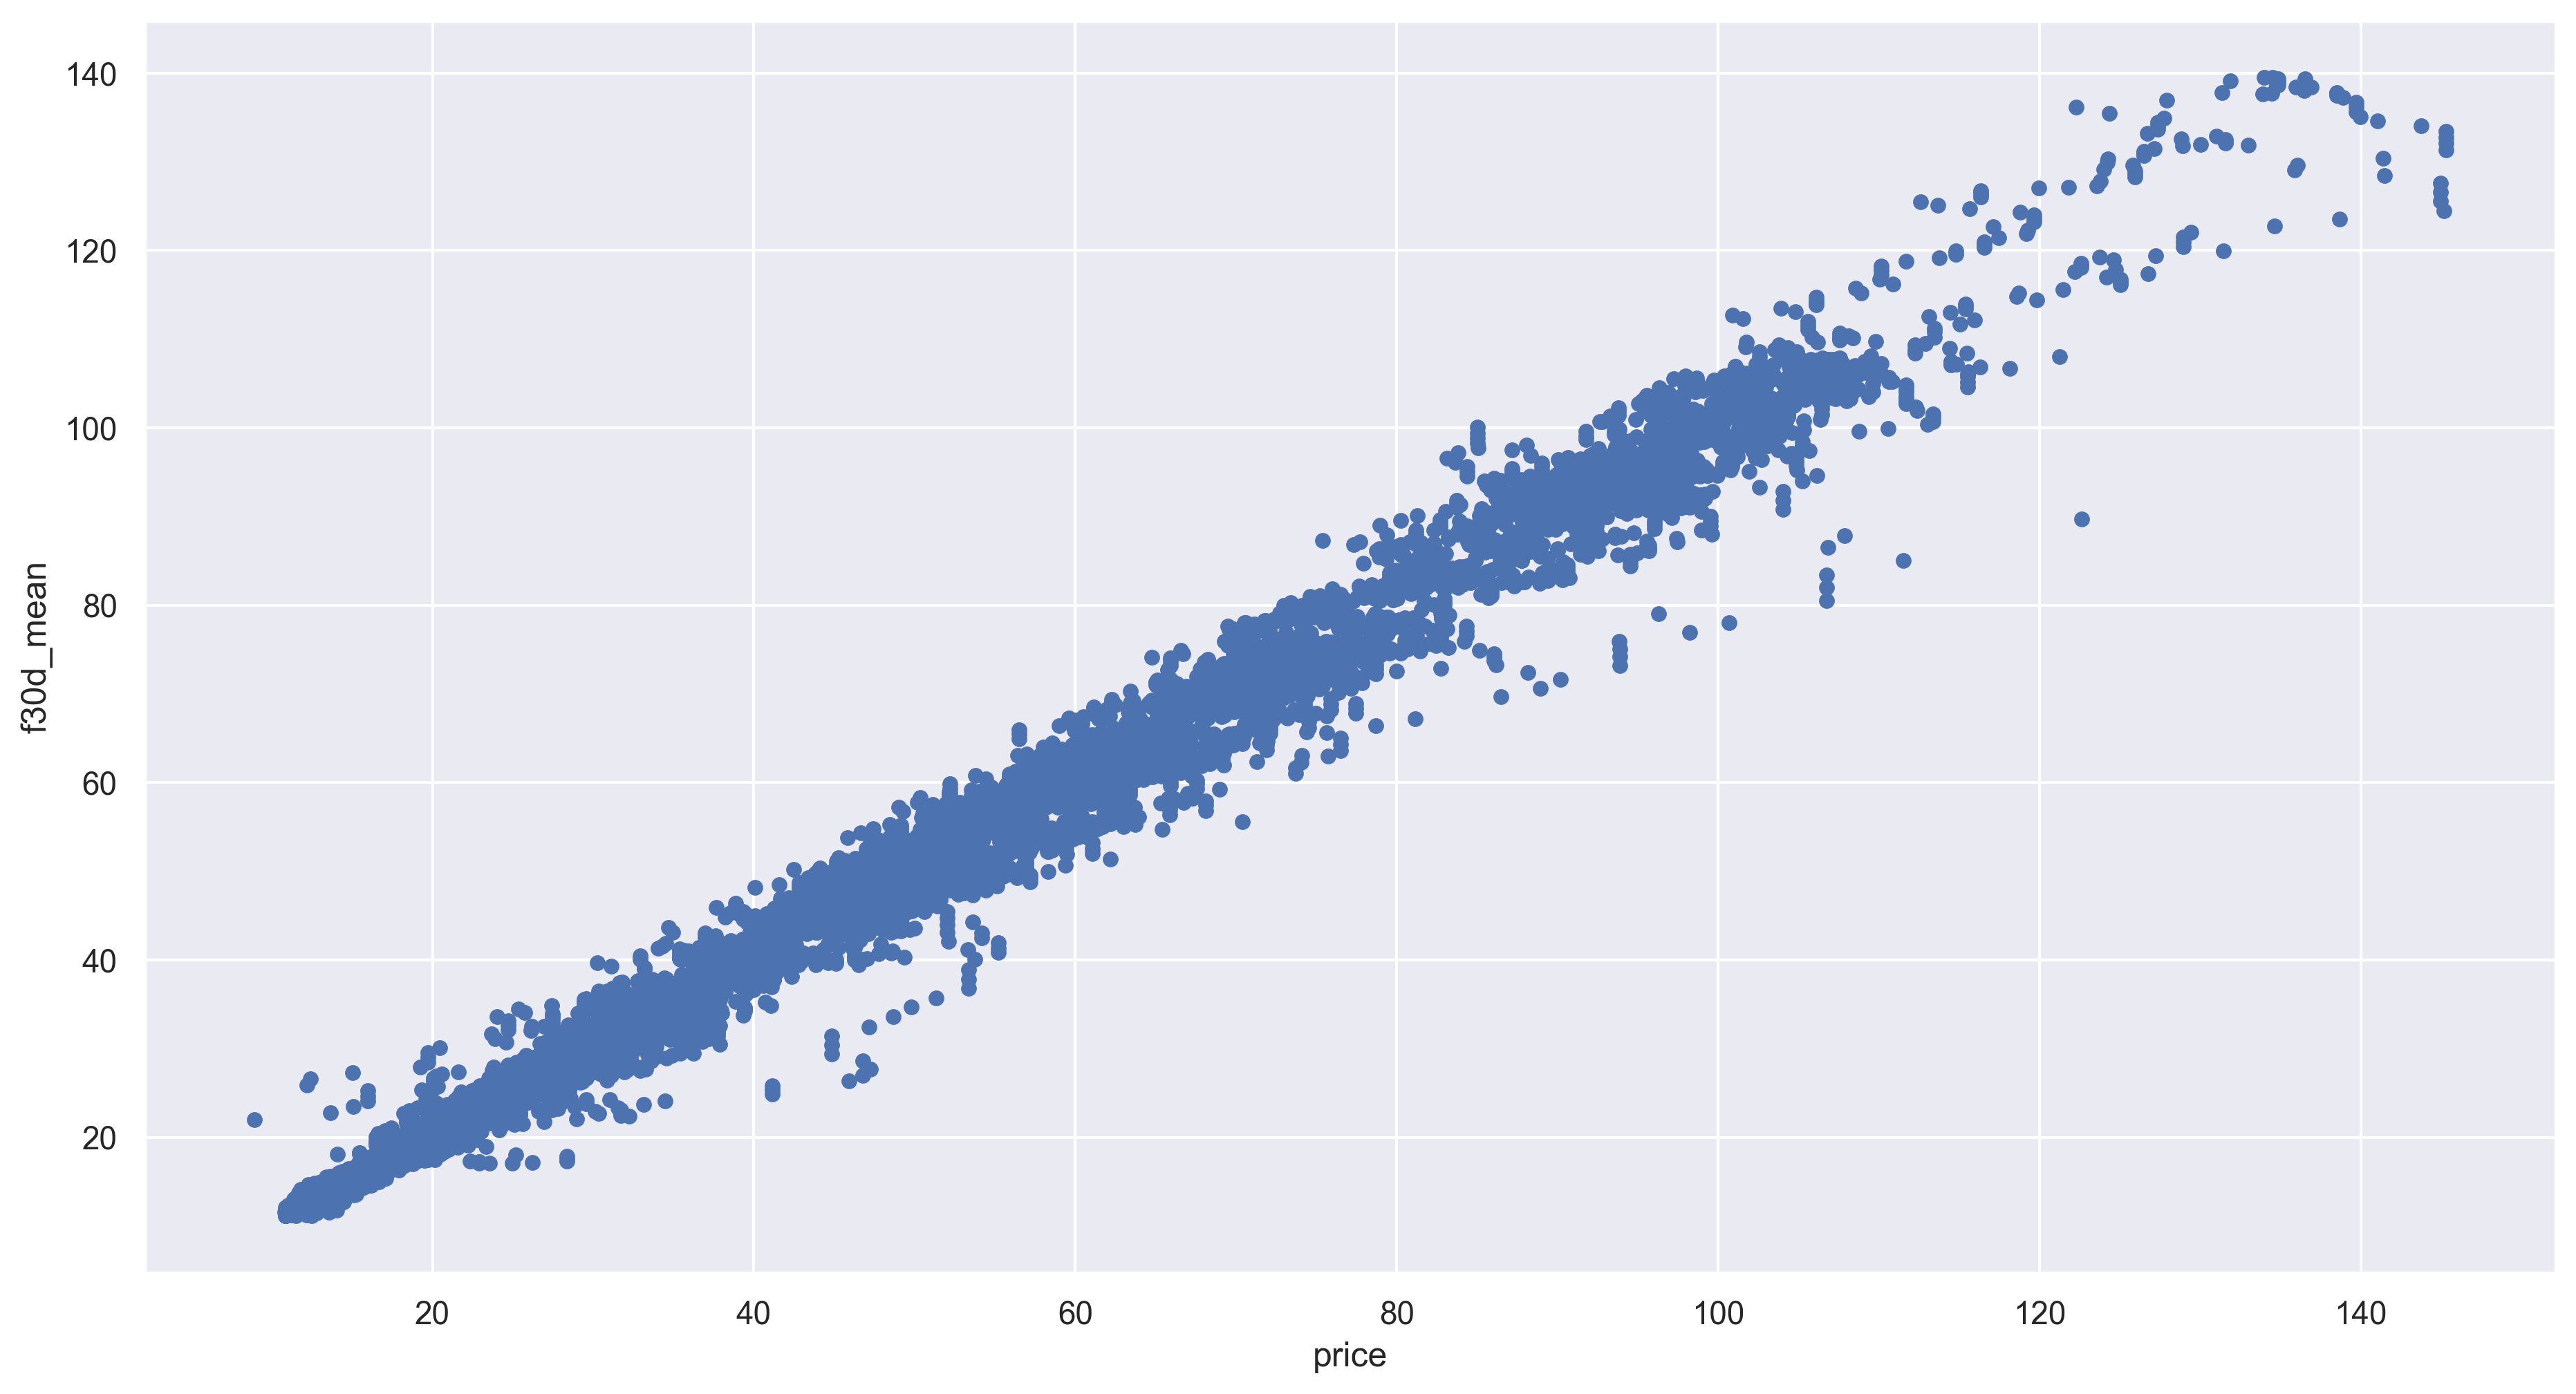

In [19]:
ts.plot.scatter(x='price', y='f30d_mean')

In [20]:
model_mse, model_mae = mse(y_test, predictions), mae(y_test, predictions)
model_mse, model_mae

(0.7974293407356523, 0.6381502892070469)

In [21]:
X_test_price = pd.DataFrame(scal.inverse_transform(X_test))[0]

base_mse, base_mae = mse(y_test, X_test_price), mae(y_test, X_test_price)
base_mse, base_mae

(9.283846522483735, 2.0102813815537695)

In [27]:
# create a dataframe from the original data, appending the 

test_df = pd.DataFrame(scal.inverse_transform(X_test), columns=X.columns)[['price']]
test_df['prediction'] = predictions
test_df['actual'] = y_test.values
test_df['pred_error'] = test_df['prediction'] - test_df['actual']
test_df['assume_const_error'] = test_df['price'] - test_df['actual']
test_df['price_dev'] = test_df['actual'] - test_df['price']

test_df

,price,prediction,actual,pred_error,assume_const_error,price_dev
0,72.73,71.815422,71.212333,0.603089,1.517667,-1.517667
1,58.08,62.682178,63.413000,-0.730822,-5.333000,5.333000
2,99.40,97.761292,98.813000,-1.051708,0.587000,-0.587000
3,24.79,26.708237,27.979667,-1.271430,-3.189667,3.189667
4,18.70,18.157524,18.701667,-0.544143,-0.001667,0.001667
...,...,...,...,...,...,...
3479,48.34,49.612076,49.547667,0.064409,-1.207667,1.207667
3480,44.08,50.941517,50.134333,0.807184,-6.054333,6.054333
3481,48.41,51.002415,51.819667,-0.817252,-3.409667,3.409667
3482,51.46,50.253765,50.064333,0.189432,1.395667,-1.395667


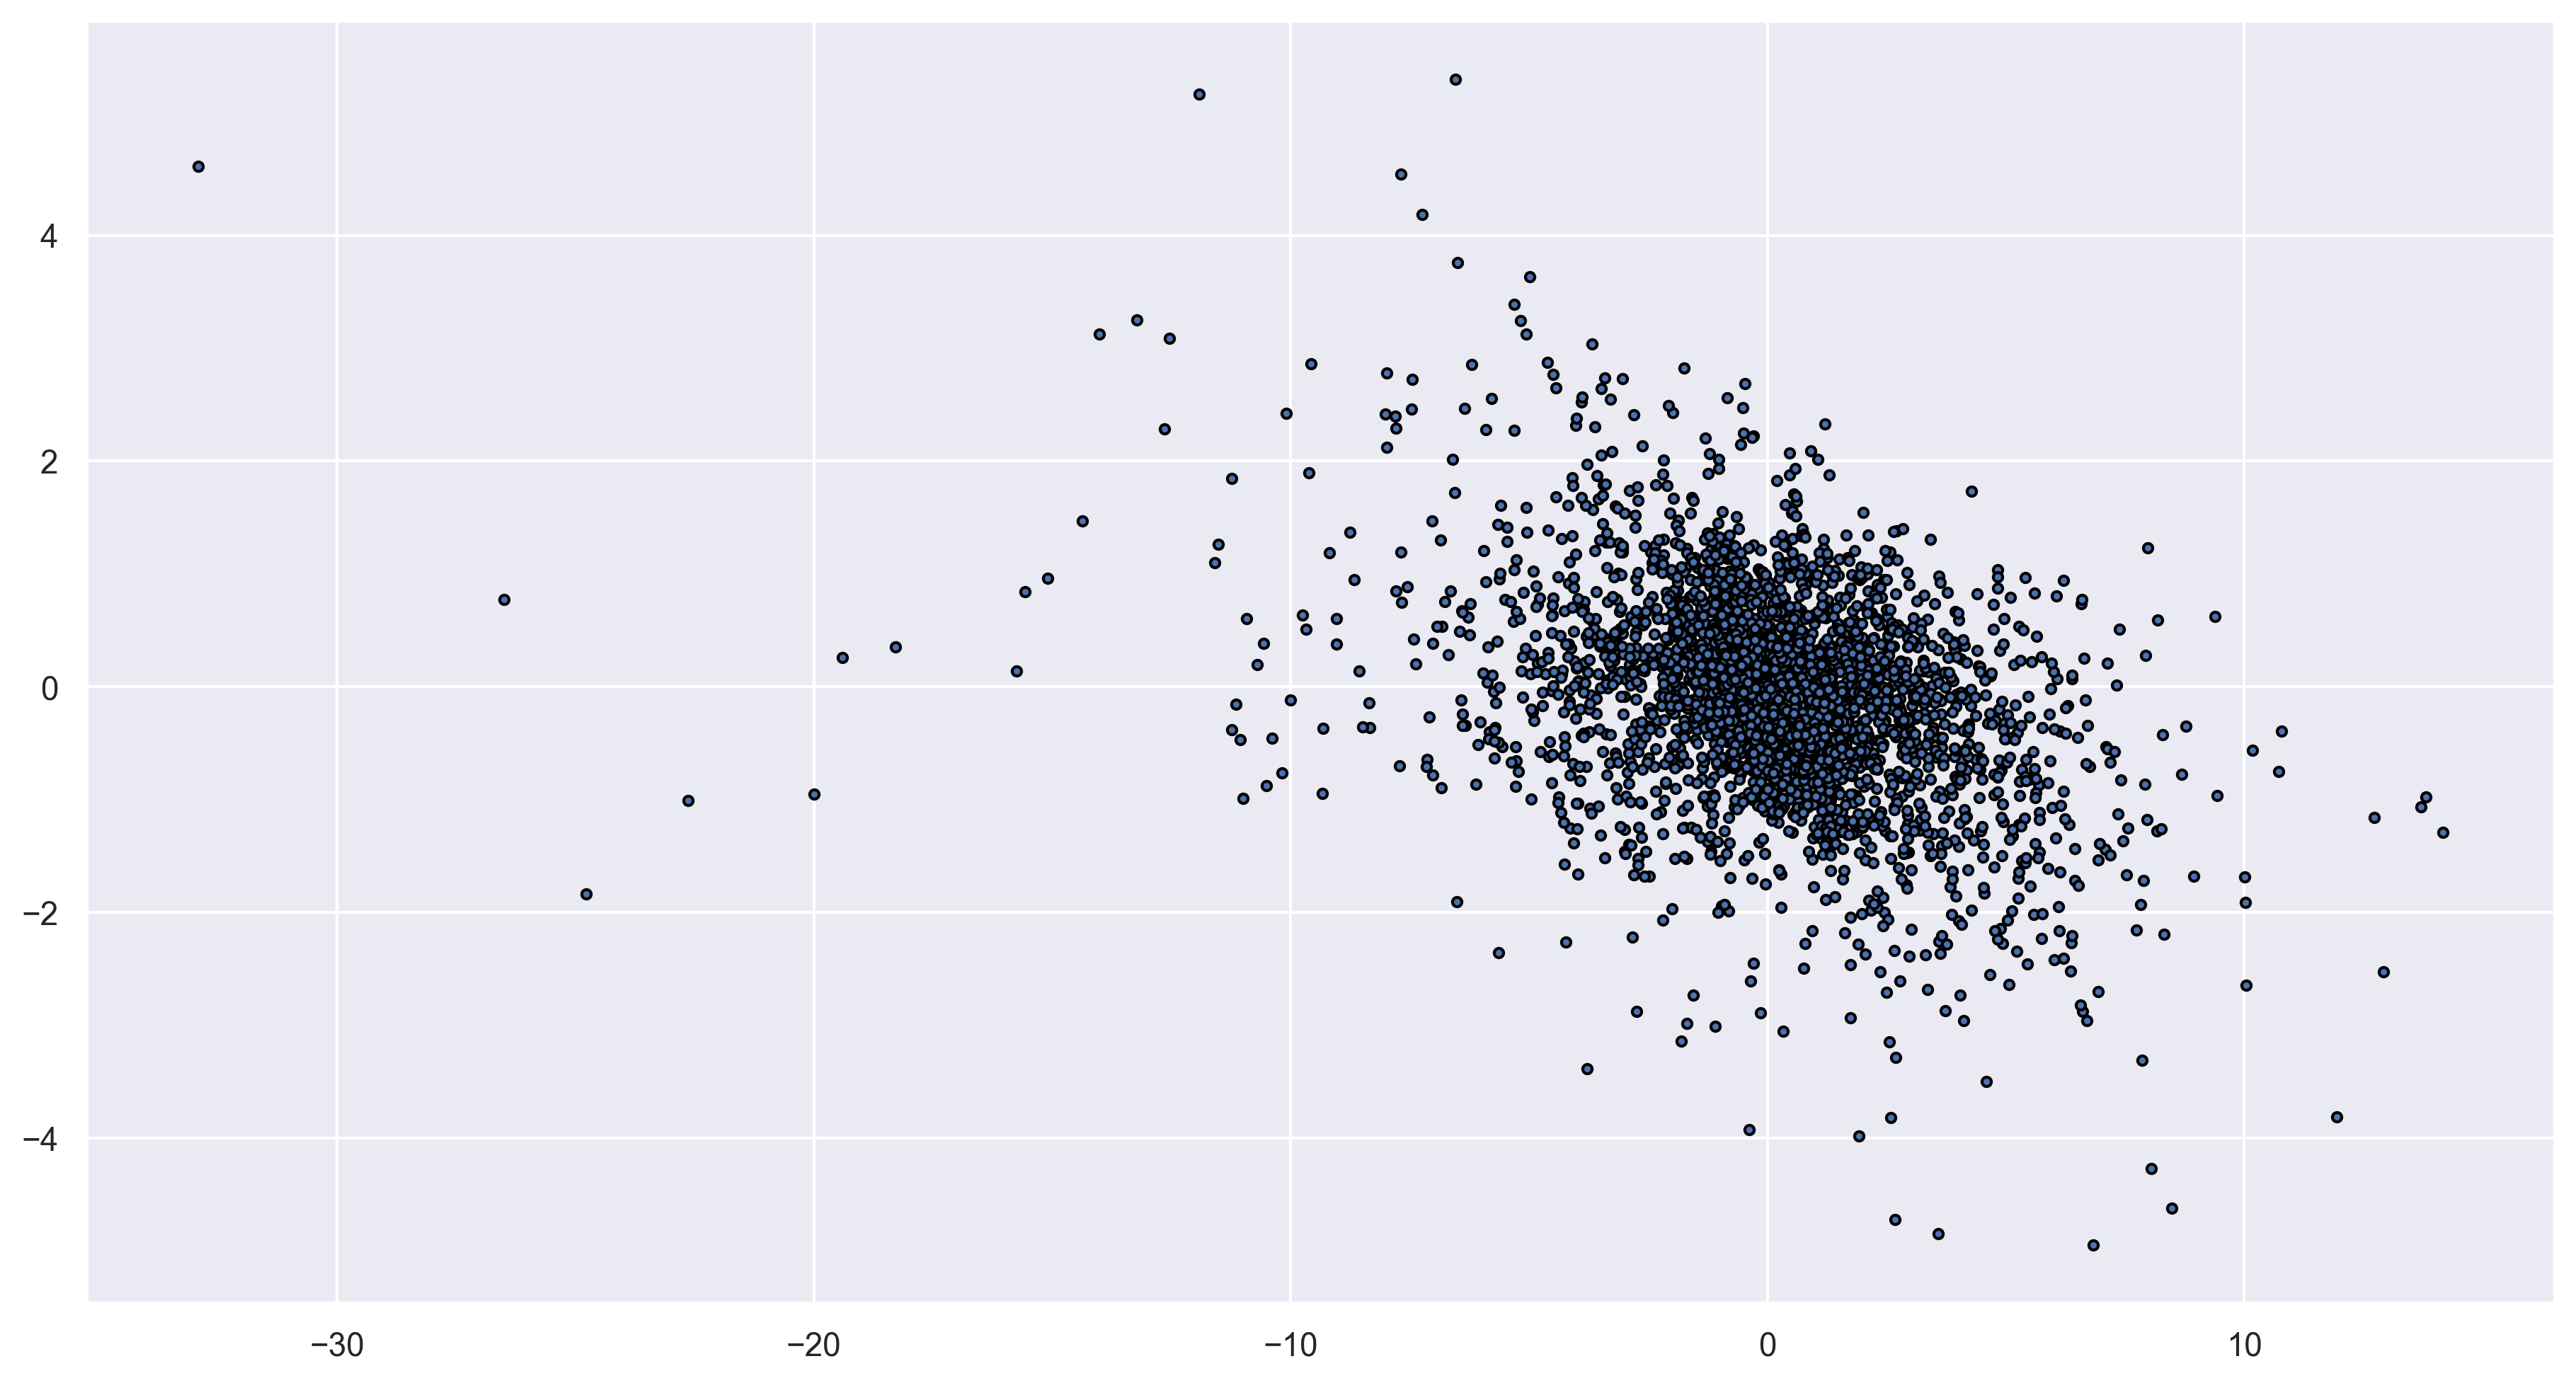

In [36]:
plt.scatter(test_df['price_dev'], test_df['pred_error'], s=10, edgecolors='black')